### DSC 680 Project 2
### Predicting Stock Performance of American Airlines Based on Economic Indicators and Vendors Stock Prices
### Shu Liu

In [61]:
# Import all the necessary libraries/packages.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb

from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim as geo
from scipy.stats import pearsonr
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score


# Import warnings and set filter warnings to ignore due to the use of deprecated code  
import warnings
warnings.filterwarnings('ignore')

#### Data sources: 

#### American Airlines Group Inc. (AAL): https://finance.yahoo.com/quote/AAL/history?period1=1262736000&period2=1703808000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

#### Airbus SE (AIR.PA): https://finance.yahoo.com/quote/AIR.PA/history?period1=1262736000&period2=1703808000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

#### Boeing (BA): https://finance.yahoo.com/quote/BA/history?period1=1262736000&period2=1703808000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

#### Deutsche Lufthansa AG (DLAKY): https://finance.yahoo.com/quote/DLAKY/history?period1=1262736000&period2=1703808000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

#### Jet fuel price: https://www.eia.gov/dnav/pet/hist/EER_EPJK_PF4_RGC_DPGD.htm

#### S&P 500 (SPY): https://finance.yahoo.com/quote/SPY/historyperiod1=1262563200&period2=1703808000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [62]:
# Read the CSV files into pandas DataFrames and assign them to variables
df_AAL = pd.read_csv('AAL.csv') # American Airlines
df_AIR = pd.read_csv('AIR.PA.csv') # Air Bus
df_BA = pd.read_csv('BA.csv') # Boeing
df_DL = pd.read_csv('DLAKY.csv') # Lufthansa
df_KE = pd.read_csv('Kerosene.csv')
df_SP = pd.read_csv('SP500.csv')

In [63]:
# Check data for Yahoo CSVs
df_AAL.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,1/4/2010,4.84,4.94,4.66,4.77,4.496876,9837300
1,1/5/2010,4.79,5.37,4.71,5.31,5.005958,25212000
2,1/6/2010,5.19,5.38,5.00,5.09,4.798555,16597900
3,1/7/2010,5.06,5.43,5.05,5.24,4.939965,14033400
4,1/8/2010,5.27,5.43,5.06,5.14,4.845692,12760000


In [64]:
# Check data for Non-Yahoo CSV
df_KE.head()

,Date,Price
0,"Jan 04, 2010",2.165
1,"Jan 05, 2010",2.165
2,"Jan 06, 2010",2.173
3,"Jan 07, 2010",2.156
4,"Jan 08, 2010",2.190


In [65]:
# List of dataframe names for use in iterations
df_names = ['AAL', 'AIR', 'BA', 'DL', 'KE', 'SP']

In [66]:
# Drop unneeded columns from Yahoo dataframes
columns_to_drop = ['Open', 'High', 'Low','AdjClose','Volume']

# Drop columns from the DataFrame
df_AAL.drop(columns=columns_to_drop, inplace=True)
df_AIR.drop(columns=columns_to_drop, inplace=True)
df_BA.drop(columns=columns_to_drop, inplace=True)
df_DL.drop(columns=columns_to_drop, inplace=True)
df_SP.drop(columns=columns_to_drop, inplace=True)

In [67]:
# Iterate through each name in the list of dataframe names
for name in df_names:
    
    # Concatenate dataframe name from list of names
    df_name = 'df_' + name
    
    # Access the DataFrame using globals() function
    current_df = globals()[df_name]
    
    # Convert the 'Date' column to datetime format
    current_df['Date'] = pd.to_datetime(current_df['Date'])
    
    # Reformat the 'Date' column to 'yyyy-mm-dd'
    current_df['Date'] = current_df['Date'].dt.strftime('%Y-%m-%d')

In [68]:
# Change column name Price to Close
df_KE.rename(columns={'Price': 'Close'}, inplace=True)

In [69]:
# Check data for Yahoo CSVs
df_AAL.head()

,Date,Close
0,2010-01-04,4.77
1,2010-01-05,5.31
2,2010-01-06,5.09
3,2010-01-07,5.24
4,2010-01-08,5.14


In [70]:
# Check data for Non-Yahoo CSV
df_KE.head()

,Date,Close
0,2010-01-04,2.165
1,2010-01-05,2.165
2,2010-01-06,2.173
3,2010-01-07,2.156
4,2010-01-08,2.190


In [72]:
# Replace NaN values in the 'Close' column with the average of the previous and next values
for name in df_names:

    # Concatenate dataframe name from list of names
    df_name = 'df_' + name
    
    # Access the DataFrame using globals() function
    current_df = globals()[df_name]

    # Convert the 'Date' column to datetime format (if not already done)
    current_df['Date'] = pd.to_datetime(current_df['Date'])

    # Replace NaN values in the 'Close' column with the average of the previous and next values
    current_df['Close'] = current_df['Close'].fillna((current_df['Close'].shift() + current_df['Close'].shift(-1)) / 2)

In [73]:
# Iterate through each name in the list of dataframe names
for name in df_names:

    # Concatenate dataframe name from list of names
    df_name = 'df_' + name
    
    # Access the DataFrame using globals() function
    current_df = globals()[df_name]

    current_df.rename(columns={'Close': f'Close_{name}'}, inplace=True)
    
    # Convert the 'Date' column to datetime format (if not already done)
    current_df['Date'] = pd.to_datetime(current_df['Date'])

In [74]:
# Merge df_AAL and df_AIR DataFrames on the 'Date' column using inner join
df_combined=pd.merge(df_AAL,df_AIR, on='Date',how='inner')

# Merge df_combined with df_BA DataFrame on the 'Date' column using inner join
df_combined=pd.merge(df_combined,df_BA, on='Date',how='inner')

# Merge df_combined with df_DL DataFrame on the 'Date' column using inner join
df_combined=pd.merge(df_combined,df_DL, on='Date',how='inner')

# Merge df_combined with df_KE DataFrame on the 'Date' column using inner join
df_combined=pd.merge(df_combined,df_KE, on='Date',how='inner')

# Merge df_combined with df_SP DataFrame on the 'Date' column using inner join
df_combined=pd.merge(df_combined,df_SP, on='Date',how='inner')

# Display the first few rows of the resulting DataFrame
df_combined.head()

,Date,Close_AAL,Close_AIR,Close_BA,Close_DL,Close_KE,Close_SP
0,2010-01-06,5.09,14.07,59.779999,17.450001,2.173,113.709999
1,2010-01-07,5.24,14.21,62.200001,17.700001,2.156,114.190002
2,2010-01-08,5.14,14.35,61.599998,18.350000,2.190,114.570000
3,2010-01-11,5.04,14.48,60.869999,18.790001,2.156,114.730003
4,2010-01-12,5.08,14.10,60.430000,18.090000,2.116,113.660004


In [75]:
# This concludes the data cleaning and feature engineering.

# Next is the EDA

In [76]:
# Display the first few rows of the DataFrame df_AAL
df_AAL.head()

,Date,Close_AAL
0,2010-01-04,4.77
1,2010-01-05,5.31
2,2010-01-06,5.09
3,2010-01-07,5.24
4,2010-01-08,5.14


In [77]:
# Display the first few rows of the combined DataFrame
df_combined.head()

,Date,Close_AAL,Close_AIR,Close_BA,Close_DL,Close_KE,Close_SP
0,2010-01-06,5.09,14.07,59.779999,17.450001,2.173,113.709999
1,2010-01-07,5.24,14.21,62.200001,17.700001,2.156,114.190002
2,2010-01-08,5.14,14.35,61.599998,18.350000,2.190,114.570000
3,2010-01-11,5.04,14.48,60.869999,18.790001,2.156,114.730003
4,2010-01-12,5.08,14.10,60.430000,18.090000,2.116,113.660004


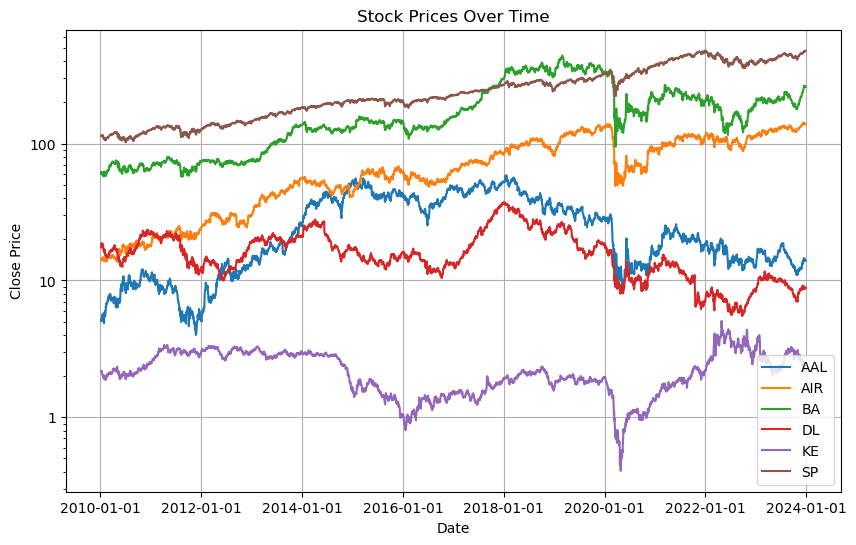

In [78]:
# Create a set of line graph in a combined logarithmic scale to check for synchronous behavious

# Convert the 'Date' column to datetime objects
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

# Plotting
plt.figure(figsize=(10, 6))

# Plot each line
for name in df_names:
    plt.plot(df_combined['Date'], df_combined[f'Close_{name}'], label=f'{str(name)}')

# Format x-axis as strings
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

# Make the y-axis logarithmic
plt.yscale('log')

# Suppress scientific notation on the y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())

# Customize the chart
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Result: While COVID distorts some of the data, in particular in 2021/22, there seems to be a good correlation 
# between AAL (American Airlines) and DL (Lufthansa, as a proxy for LSG catering) and to a lesser effect with 
# BA (Boeing)

In [79]:
# Define scatterplot
def scatterplot(stock1, stock2, subtitle):
    
    # Plotting
    plt.figure(figsize=(10, 6))

    # Scatterplot for the two stocks with rainbow color scheme based on dates
    scatter = plt.scatter(df_combined[f'Close_{stock1}'], df_combined[f'Close_{stock2}'],
                          c=mdates.date2num(df_combined['Date']), cmap='rainbow')

    # Adding a colorbar for reference
    colorbar = plt.colorbar(scatter, label='Date')

    # Suppress ticks on the colorbar
    colorbar.ax.yaxis.set_ticks([])

    # Set plot title, axis labels, and subtitle
    plt.title(f'Scatterplot of {stock1} vs {stock2} \n({subtitle})')
    plt.xlabel(f'Close Price {stock1}')
    plt.ylabel(f'Close Price {stock2}')
    plt.grid(True)
    plt.show()

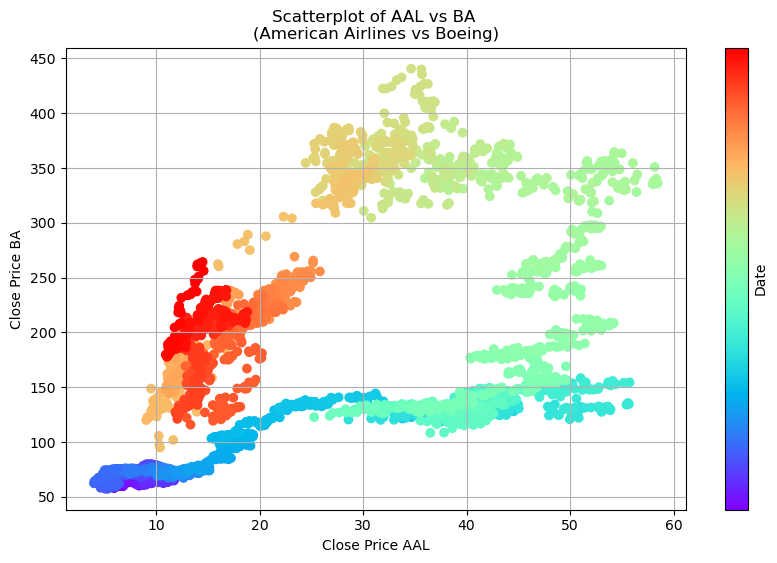

In [80]:
# Define the name of the first stock
stock1 = 'AAL'

# Define the name of the second stock
stock2 = 'BA'

# Define a subtitle for the scatterplot
subtitle = 'American Airlines vs Boeing'

# Call the scatterplot function with the specified stocks and subtitle
scatterplot(stock1, stock2, subtitle)

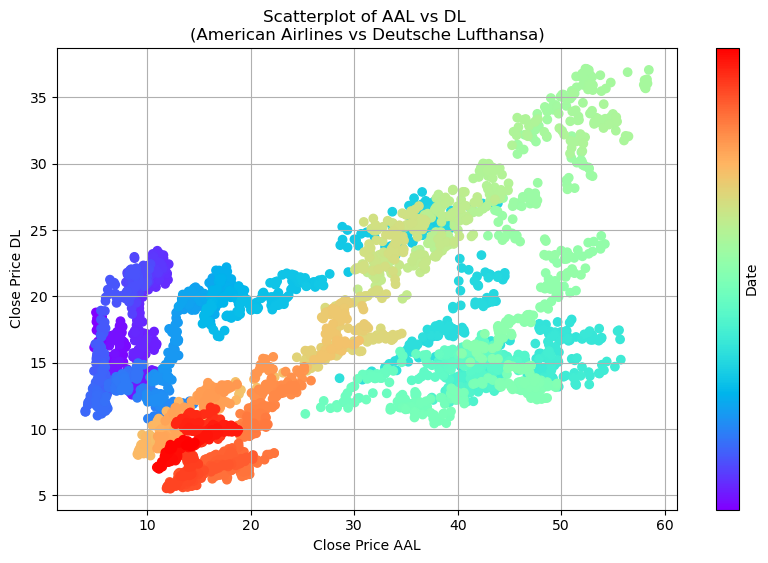

In [81]:
# Define the name of the first stock
stock1 = 'AAL'

# Define the name of the second stock
stock2 = 'DL'

# Define a subtitle for the scatterplot
subtitle = 'American Airlines vs Deutsche Lufthansa'

# Call the scatterplot function with the specified stocks and subtitle
scatterplot(stock1, stock2, subtitle)

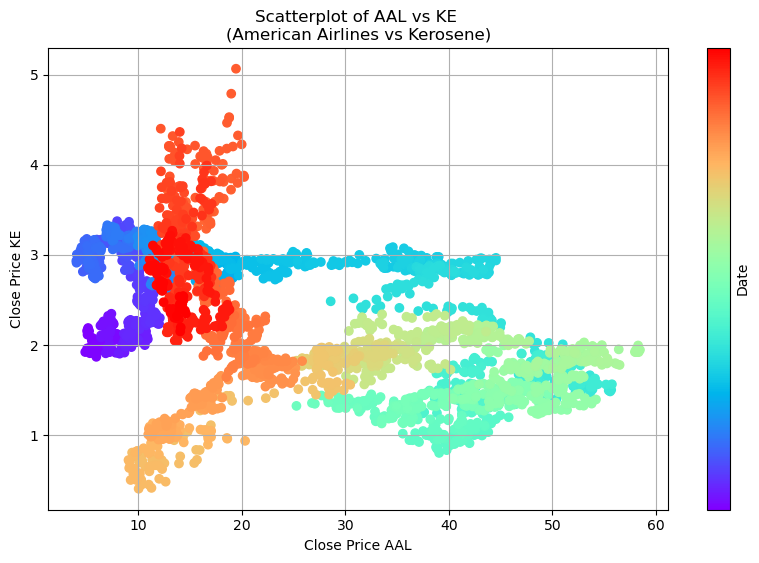

In [82]:
# Define the name of the first stock
stock1 = 'AAL'

# Define the name of the second stock
stock2 = 'KE'

# Define a subtitle for the scatterplot
subtitle = 'American Airlines vs Kerosene'

# Call the scatterplot function with the specified stocks and subtitle
scatterplot(stock1, stock2, subtitle)

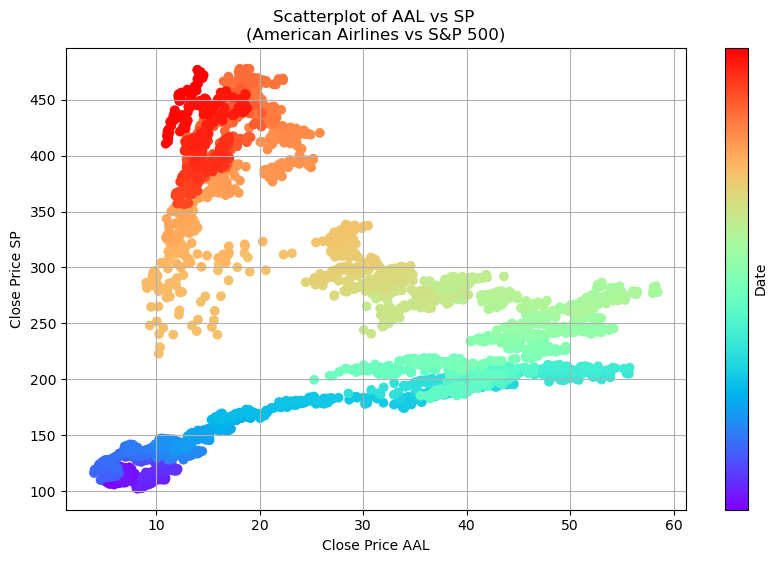

In [83]:
# Define the name of the first stock
stock1 = 'AAL'

# Define the name of the second stock
stock2 = 'SP'

# Define a subtitle for the scatterplot
subtitle = 'American Airlines vs S&P 500'

# Call the scatterplot function with the specified stocks and subtitle
scatterplot(stock1, stock2, subtitle)

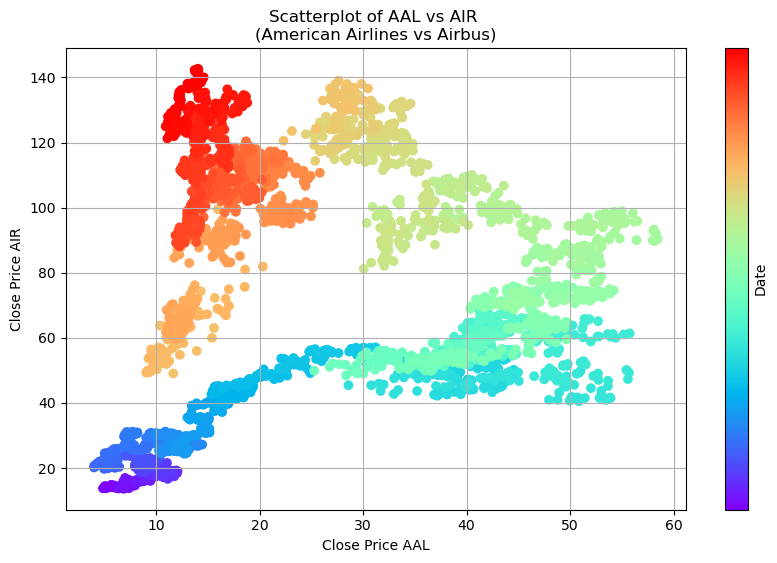

In [84]:
# Define the name of the first stock
stock1 = 'AAL'

# Define the name of the second stock
stock2 = 'AIR'

# Define a subtitle for the scatterplot
subtitle = 'American Airlines vs Airbus'

# Call the scatterplot function with the specified stocks and subtitle
scatterplot(stock1, stock2, subtitle)

In [85]:
# Results: The data sets were reasonably clean with a few missing and duplicate dates as well as some NaN values.
# Where possible NaNs were replaced with averages, or the rows were deleted (as we have more than enough data).
# Initial graphical analysis indicates plenty of correlation betwee several of the stock, which means the datasets
# will serve my purposes.

# This concludes the EDA

# Next is the Feature Engineering

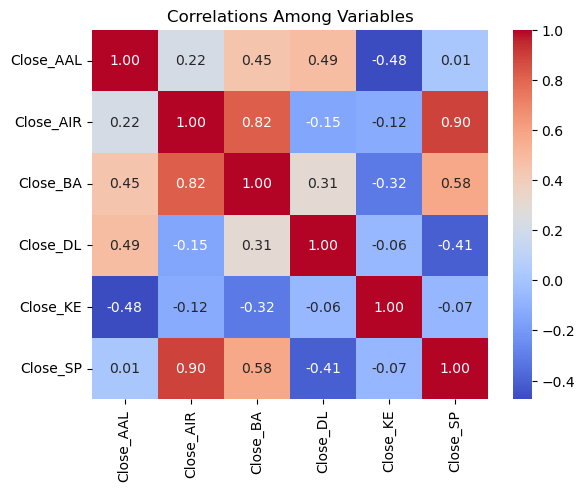

In [86]:
# Determining the best correlation between AAL (American Airlines) and the chosen indicators

# Create a correlation matrix
correlation_matrix = df_combined[['Close_AAL', 'Close_AIR', 'Close_BA', 'Close_DL', 'Close_KE', 'Close_SP']].corr()

# Plotting the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title to the heatmap
plt.title('Correlations Among Variables')

# Show the plot
plt.show()

In [87]:
# Save the combined DataFrame to a CSV file named 'temp.csv'
df_combined.to_csv('temp.csv', index=False)

In [88]:
# Function to find covariance and correlation between two stocks
def find_covariance_and_correlation(stock1, stock2, value_columns):
    # Calculate covariance between stock1 and value_columns
    covariance_result = df_combined[[stock1, value_columns]].cov().iloc[0, 1]
    
    # Calculate Pearson's correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(df_combined[stock1], df_combined[value_columns])
    
    # Print the results
    print(f'AAL and {stock2}: Covariance = {covariance_result:.2f}, Pearson\'s Correlation = {correlation_coefficient:.2f}')
        
# Drop any NaN rows/values left
df_combined.dropna(inplace=True)    

# Iterate through stock names and calculate covariance and correlation with 'Close_AAL'
for name in df_names[1:]:
    find_covariance_and_correlation('Close_AAL', name, 'Close_' + name)

AAL and AIR: Covariance = 116.68, Pearson's Correlation = 0.22
AAL and BA: Covariance = 616.80, Pearson's Correlation = 0.45
AAL and DL: Covariance = 45.74, Pearson's Correlation = 0.49
AAL and KE: Covariance = -5.25, Pearson's Correlation = -0.48
AAL and SP: Covariance = 14.12, Pearson's Correlation = 0.01


In [89]:
# Result: This confirms my original impression during the EDA, that the stongest correlation exists between 
# American Airlines (AAL) and Boeing (BA), Lufthansa (DL; as proxy for LSG Catering), and also a negative 
# correlation to fuel prices (KE). Therefore, I will remove the S&P 500 (SP) and Airbus (AIR) for modeling.

In [90]:
# Display the first few rows of the combined DataFrame
df_combined.head()

,Date,Close_AAL,Close_AIR,Close_BA,Close_DL,Close_KE,Close_SP
0,2010-01-06,5.09,14.07,59.779999,17.450001,2.173,113.709999
1,2010-01-07,5.24,14.21,62.200001,17.700001,2.156,114.190002
2,2010-01-08,5.14,14.35,61.599998,18.350000,2.190,114.570000
3,2010-01-11,5.04,14.48,60.869999,18.790001,2.156,114.730003
4,2010-01-12,5.08,14.10,60.430000,18.090000,2.116,113.660004


In [91]:
# Save the combined DataFrame to a CSV file with the specified path
df_combined.to_csv("C:\\Users\\Owner\\df_combined.csv")

In [92]:
# Drop AIR and SP from dataframe
columns_to_drop = ['Close_AIR','Close_SP']
df_combined.drop(columns=columns_to_drop, inplace=True)

,Date,Close_AAL,Close_BA,Close_DL,Close_KE
0,2010-01-06,5.09,59.779999,17.450001,2.173
1,2010-01-07,5.24,62.200001,17.700001,2.156
2,2010-01-08,5.14,61.599998,18.350000,2.190
3,2010-01-11,5.04,60.869999,18.790001,2.156
4,2010-01-12,5.08,60.430000,18.090000,2.116


In [93]:
# Read the CSV file into a DataFrame from the specified path
df=pd.read_csv("C:\\Users\\Owner\\df_combined.csv")

In [94]:
# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,Date,Close_AAL,Close_AIR,Close_BA,Close_DL,Close_KE,Close_SP
0,0,2010-01-06,5.09,14.07,59.779999,17.450001,2.173,113.709999
1,1,2010-01-07,5.24,14.21,62.200001,17.700001,2.156,114.190002
2,2,2010-01-08,5.14,14.35,61.599998,18.350000,2.190,114.570000
3,3,2010-01-11,5.04,14.48,60.869999,18.790001,2.156,114.730003
4,4,2010-01-12,5.08,14.10,60.430000,18.090000,2.116,113.660004


In [95]:
# Select the features (independent variables) for X
X = df[['Close_AIR', 'Close_BA', 'Close_DL', 'Close_KE', 'Close_SP']]

# Select the target variable (dependent variable) for y
y = df['Close_AAL']

In [96]:
# Display the features (independent variables) X
X

,Close_AIR,Close_BA,Close_DL,Close_KE,Close_SP
0,14.070000,59.779999,17.450001,2.173,113.709999
1,14.210000,62.200001,17.700001,2.156,114.190002
2,14.350000,61.599998,18.350000,2.190,114.570000
3,14.480000,60.869999,18.790001,2.156,114.730003
4,14.100000,60.430000,18.090000,2.116,113.660004
...,...,...,...,...,...
3468,137.880005,260.250000,8.760000,2.537,468.260010
3469,138.520004,262.019989,8.840000,2.541,472.700012
3470,139.440002,260.440002,8.760000,2.498,473.649994
3471,139.419998,262.100006,8.900000,2.451,476.510010


In [97]:
# Select the target variable (dependent variable) y
y

0        5.09
1        5.24
2        5.14
3        5.04
4        5.08
        ...  
3468    13.98
3469    14.35
3470    14.31
3471    13.99
3472    13.98
Name: Close_AAL, Length: 3473, dtype: float64

In [98]:
# Import the MinMaxScaler class from the sklearn.preprocessing module
from sklearn.preprocessing import MinMaxScaler

# Create an instance of the MinMaxScaler
sc = MinMaxScaler()

# Scale the features (independent variables) using the MinMaxScaler and compute the scaling parameters
X_scaled = sc.fit_transform(X)

In [99]:
# Display the scaled features (independent variables) after scaling
X_scaled

array([[0.00321643, 0.0061846 , 0.37744792, 0.3790513 , 0.03065165],
       [0.00430149, 0.01249968, 0.38534431, 0.37540245, 0.03192992],
       [0.00538655, 0.01093395, 0.40587492, 0.38270015, 0.03294187],
       ...,
       [0.97488866, 0.52981395, 0.10296905, 0.44880876, 0.98918805],
       [0.97473362, 0.53414579, 0.10739103, 0.43872076, 0.9968044 ],
       [0.97674869, 0.5295791 , 0.10549589, 0.42455463, 0.99728372]])

In [100]:
# Create an instance of the MinMaxScaler for scaling the target variable
sc1 = MinMaxScaler()

# Reshape the target variable y to a 2D array with one column using the reshape method
y_reshape = y.values.reshape(-1, 1)

# Scale the reshaped target variable using the MinMaxScaler and compute the scaling parameters
y_scaled = sc1.fit_transform(y_reshape)

In [101]:
# Display the scaled target variable after scaling
y_scaled

array([[0.02001101],
       [0.02276482],
       [0.02092895],
       ...,
       [0.1892785 ],
       [0.18340371],
       [0.18322012]])

In [102]:
# Splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)

In [103]:
# Create an instance of the LinearRegression model
lr = LinearRegression()

# Train the LinearRegression model on the training data
lr.fit(X_train, y_train)

LinearRegression()

In [104]:
# Making predictions using lr model
y_pred = lr.predict(X_test)

In [105]:
# Calculate metrics (Mean Squared Error and R-squared)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [106]:
# Print the model's coefficients and metrics
print(f'Coefficients: {lr.coef_}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Coefficients: [[ 0.90698476 -0.48141295  0.75665936 -0.81530711 -0.37426646]]
Mean Squared Error: 0.03343129831081132
R-squared: 0.5296010242457736


In [107]:
# Read the CSV file into a DataFrame from the specified path
df = pd.read_csv('C:\\Users\\Owner\\df_combined.csv')

# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,Date,Close_AAL,Close_AIR,Close_BA,Close_DL,Close_KE,Close_SP
0,0,2010-01-06,5.09,14.07,59.779999,17.450001,2.173,113.709999
1,1,2010-01-07,5.24,14.21,62.200001,17.700001,2.156,114.190002
2,2,2010-01-08,5.14,14.35,61.599998,18.350000,2.190,114.570000
3,3,2010-01-11,5.04,14.48,60.869999,18.790001,2.156,114.730003
4,4,2010-01-12,5.08,14.10,60.430000,18.090000,2.116,113.660004


In [108]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

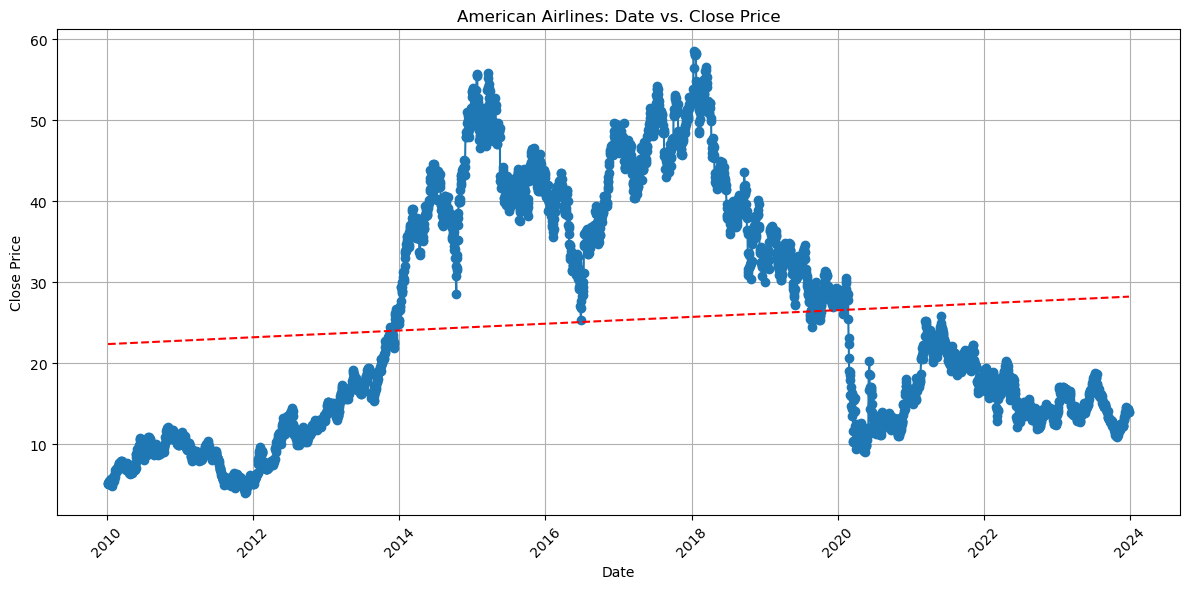

In [109]:
# Create the line chart
plt.figure(figsize=(12, 6))

# Plot the Close_AAL data against the Date
plt.plot(df['Date'], df['Close_AAL'], marker='o', linestyle='-')

# Calculate the trendline
z = np.polyfit(range(len(df)), df['Close_AAL'], 1)
p = np.poly1d(z)

# Plot the trendline
plt.plot(df['Date'], p(range(len(df))), linestyle='--', color='red')

# Set the title and axis labels
plt.title('American Airlines: Date vs. Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True) # Add a grid to the plot
plt.xticks(rotation=45) # Rotate x-axis labels for better readability

# Adjust layout to prevent clipping of axis labels
plt.tight_layout()

# Display the plot
plt.show()

In [110]:
# Result: 
# Mean Squared Error: 0.03343129831081132
# R-squared: 0.5296010242457736 
# It shows a positive slope with some volatilities. It shows a down-trend after 2020 which might due to the pandemic.

# While the linear regression is indicating a matching long-term trend, it is nearly useless for
# short-term predictions of stock price movements of American Airlines.

In [111]:
# Extract the 'Date' column as the independent variable (X) and reshape it for compatibility with scikit-learn
X = df['Date'].values.reshape(-1, 1)

# Extract the 'Close_AAL' column as the dependent variable (y)
y = df['Close_AAL'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

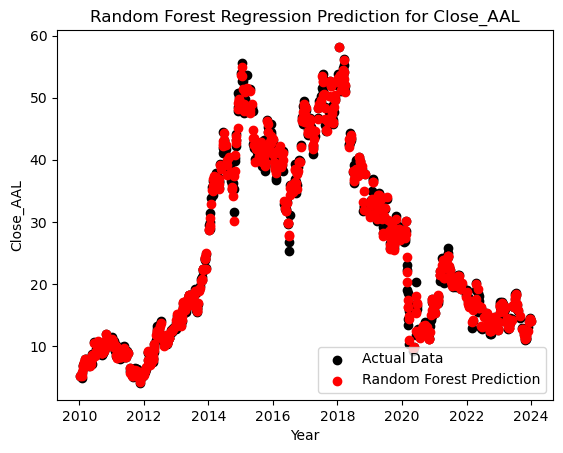

Mean Squared Error: 0.40983580449722673
R-squared: 0.998132803339772


In [112]:
# Create a Random Forest Regressor model with 100 decision trees and a random state of 42
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Visualization
plt.scatter(X_test, y_test, color='black', label='Actual Data')
plt.scatter(X_test, y_pred, color='red', label='Random Forest Prediction')
plt.title('Random Forest Regression Prediction for Close_AAL')
plt.xlabel('Year')
plt.ylabel('Close_AAL')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test)**2)

# Calculate R-squared
r_squared = model.score(X_test, y_test)

# Print the evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

In [113]:
# Result

# The Ramdom Forest Regressor is dead-on with a R-squared value of 0.998. This qualifies this model to be used for 
# predicting stock price changes for American Airlines stock, based on the Boeing and Lufthansa (as proxy for LSG 
# catering), as well as the fuel (kerosene) prices (negaive correlation).

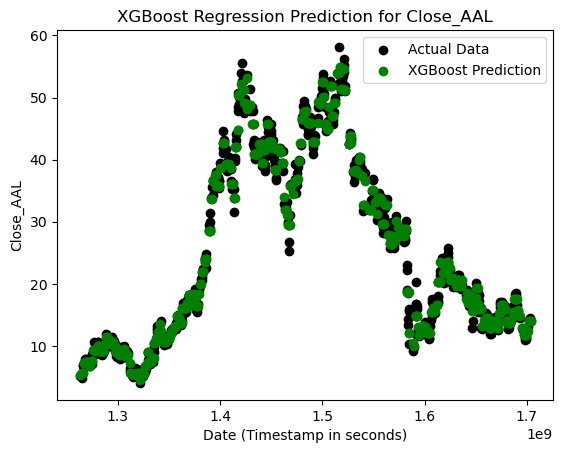

Mean Squared Error: 1.40877709402938
R-squared: 0.9935816640320031


In [114]:
# Convert the 'Date' column to Timestamp in seconds and store it in a new column 'Timestamp'
df['Timestamp'] = df['Date'].astype(np.int64) // 10**9  # Convert nanoseconds to seconds

# Use 'Timestamp' as the independent variable (X)
X = df['Timestamp'].values.reshape(-1, 1)
y = df['Close_AAL'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Visualization
plt.scatter(X_test, y_test, color='black', label='Actual Data')
plt.scatter(X_test, y_pred, color='green', label='XGBoost Prediction')
plt.title('XGBoost Regression Prediction for Close_AAL')
plt.xlabel('Date (Timestamp in seconds)')
plt.ylabel('Close_AAL')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test)**2)

# Calculate R-squared
r_squared = model.score(X_test, y_test)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

In [115]:
# Result

# The XGBoost Regression is very accurate with a R-squared value of 0.993. While this is good, it is not the same 
# quality as the Random Forest Regressor, as it misses some of the highs and lows, having a mean squared error of 
# 1.41, particularly in the more volatile mid-section of the dataset.

In [116]:
# Conclusion

# The linear regression is all but useless for my purpose, as the only thing it can do, is to offer a long-term
# trend prediction. XGBoost provides a good fit for this project, but misses some of the extremes in the volatile 
# areas of the dataset, with a lower R-squared and higer mean squared error. The most accurate model of the ones
# compared here is the Random Forest Regressor, with a near perfect R-squared and a low error rate.

In [117]:
# Ethical Considerations

# As with any statistical or predictive analysis of financial data, designed to advise investors, it is important 
# to offer full disclosure of the data and methods used, as well as to offer a very clear disclaimer, that any
# past analysis cannot guarantee future performance. Additionally, it is a good idea to stress the fact that, even
# though an analysis like this can be a good guideline to picking an investment, but that there are many more, and
# some entirely unforeseeable factors that may upend even the best predictions. Point in case: The COVID pandemic,
# which affected the entire industry negatively and was completely unpredictable.